# Mini-GPT text prediction

In [138]:
# Import packages
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [139]:
# Import dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-06-26 20:26:25--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  --.-KB/s    in 0.1s    

2024-06-26 20:26:25 (11.2 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



In [140]:
device = 'mps'

In [141]:
with open('input.txt', 'r', encoding = 'utf-8') as file:
    data_str = file.read()
print(f'length of dataset (characters): {len(data_str)}')
print(f'first 100 characters: {data_str[:300]}')

length of dataset (characters): 1115394
first 100 characters: First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


In [142]:
# Establish 'vocabulary' of characters
chars = sorted(list(set(data_str)))
data_size, vocab_size = len(data_str), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')
print(''.join(chars))

# Create dictionaries to convert characters to integers and vice versa
char_to_ix = {ch:i for i,ch in enumerate(chars)}
ix_to_char = {i:ch for i,ch in enumerate(chars)}


data has 1115394 characters, 65 unique.

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [143]:
# Encoder takes a string and retuns a list of integers
encode = lambda string: [char_to_ix[ch] for ch in string]
decode = lambda lst: ''.join([ix_to_char[int(ix)] for ix in lst])

usript = input('Enter text to encode: ')
print(f'Encoded: {encode(usript)}, Decoded: {decode(encode(usript))}')

Encoded: [46], Decoded: h


In [144]:
data = torch.tensor(encode(data_str), dtype=torch.long, device = device)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59], device='mps:0')


In [148]:
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [149]:
batch_size = 16
block_size = 32
lr = 1e-3
steps = 5000
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

In [150]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f'Context: {context}, Target: {target}')
    print(f'Decoded: {decode(context)} -> {decode([target])}')

Context: tensor([18], device='mps:0'), Target: 47
Decoded: F -> i
Context: tensor([18, 47], device='mps:0'), Target: 56
Decoded: Fi -> r
Context: tensor([18, 47, 56], device='mps:0'), Target: 57
Decoded: Fir -> s
Context: tensor([18, 47, 56, 57], device='mps:0'), Target: 58
Decoded: Firs -> t
Context: tensor([18, 47, 56, 57, 58], device='mps:0'), Target: 1
Decoded: First ->  
Context: tensor([18, 47, 56, 57, 58,  1], device='mps:0'), Target: 15
Decoded: First  -> C
Context: tensor([18, 47, 56, 57, 58,  1, 15], device='mps:0'), Target: 47
Decoded: First C -> i
Context: tensor([18, 47, 56, 57, 58,  1, 15, 47], device='mps:0'), Target: 58
Decoded: First Ci -> t
Context: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58], device='mps:0'), Target: 47
Decoded: First Cit -> i
Context: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47], device='mps:0'), Target: 64
Decoded: First Citi -> z
Context: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64], device='mps:0'), Target: 43
Decoded: First Citiz -> e


In [151]:
# Attention mechanism

class Head(nn.Module):
    """One-headed self attention mechanism"""
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias = False)
        self.query = nn.Linear(n_embd, head_size, bias = False)
        self.value = nn.Linear(n_embd, head_size, bias = False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        K = self.key(x) # (B,T,C)
        Q = self.query(x) # (B,T,C)
        # Compute attention scores
        wei = Q@K.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # Apply attention scores to values
        V = self.value(x)
        att = wei @ V
        return att
    
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [152]:
torch.manual_seed(1443)

class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Each token reads off the logits for the next token
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
model.to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'parameters')



0.209729 parameters


In [153]:
torch.manual_seed(1443)

# batch_size = 32
# block_size = 8
# lr = 1e-3
# steps = 1000
# n_embd = 32
# n_head = 4
# n_layer = 4
# dropout = 0.0

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, data.size(0) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+1+block_size] for i in ix])
    return x, y

x_batch, y_batch = get_batch('train')
print('inputs:')
print(x_batch.shape)
print(x_batch)
print('targets:')
print(y_batch.shape)
print(y_batch)

inputs:
torch.Size([16, 32])
tensor([[ 0, 28, 56, 53, 41, 50, 39, 47, 51,  1, 47, 58,  6,  1, 54, 56, 53, 60,
         53, 57, 58,  6,  1, 56, 53, 59, 52, 42,  1, 39, 40, 53],
        [10,  1, 47, 44,  1, 58, 46, 39, 58,  1, 41, 53, 51, 43,  1, 57, 46, 53,
         56, 58,  6,  0, 27, 59, 56,  1, 57, 59, 40, 57, 58, 47],
        [ 1, 46, 39, 60, 43,  1, 42, 47, 57, 54, 39, 58, 41, 46,  5, 42,  0, 35,
         47, 58, 46,  1, 50, 43, 58, 58, 43, 56, 57,  1, 53, 44],
        [46, 43, 57, 43,  1, 43, 63, 43, 57,  1, 53, 44,  1, 51, 47, 52, 43,  0,
         27, 56,  1, 44, 53, 56, 58, 59, 52, 43,  1, 45, 47, 60],
        [58, 47, 53, 52, 11,  1, 63, 53, 59,  1, 57, 46, 39, 50, 50,  0, 54, 43,
         56, 41, 43, 47, 60, 43,  1, 58, 46, 39, 58,  1, 39,  1],
        [56,  6,  0, 15, 59, 58,  1, 53, 44, 44,  1, 58, 46, 43,  1, 46, 43, 39,
         42, 57,  1, 53, 44,  1, 58, 53, 53,  1, 44, 39, 57, 58],
        [ 6,  1, 47, 52,  1, 37, 53, 56, 49, 57, 46, 47, 56, 43,  1, 39, 56, 43,
        

0.209729 parameters
step 10, loss: 3.60117244720459
step 20, loss: 3.4669625759124756
step 30, loss: 3.0840859413146973
step 40, loss: 3.0595035552978516
step 50, loss: 2.9615254402160645
step 60, loss: 2.873871088027954
step 70, loss: 2.769955635070801
step 80, loss: 2.7063753604888916
step 90, loss: 2.7173914909362793
step 100, loss: 2.5884854793548584
step 110, loss: 2.6046488285064697
step 120, loss: 2.610779285430908
step 130, loss: 2.587836503982544
step 140, loss: 2.6302900314331055
step 150, loss: 2.598050117492676
step 160, loss: 2.4461402893066406
step 170, loss: 2.4879050254821777
step 180, loss: 2.543548107147217
step 190, loss: 2.4333014488220215
step 200, loss: 2.553431272506714
step 210, loss: 2.5812222957611084
step 220, loss: 2.5023536682128906
step 230, loss: 2.541884183883667
step 240, loss: 2.3150887489318848
step 250, loss: 2.435875415802002
step 260, loss: 2.3891899585723877
step 270, loss: 2.4788079261779785
step 280, loss: 2.4960851669311523
step 290, loss: 2.43

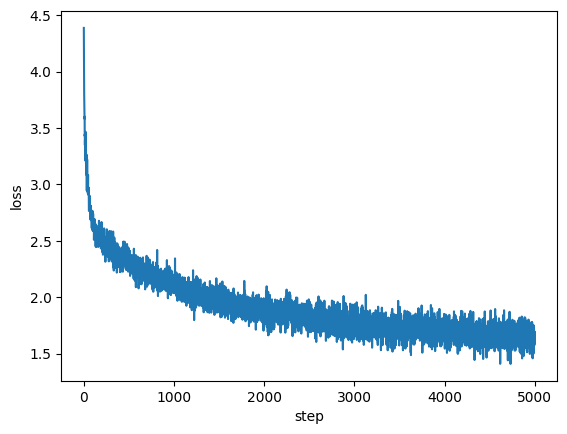

In [154]:
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'parameters')
losses = []
for steps in range(1,steps+1):

    x_batch, y_batch = get_batch('train')

    logits, loss = model(x_batch, y_batch)
    optimiser.zero_grad(set_to_none=True)
    loss.backward()
    optimiser.step()
    losses += [loss.item()]
    if steps % 10 == 0:
        print(f'step {steps}, loss: {loss.item()}')

    
# plot losses
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')
plt.show()

In [155]:
model.to('mps')
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device='mps')
print(decode(model.generate(context, max_new_tokens=900)[0].tolist()))


And blood thou tulo boot frience mysen:
I all will warwiccer: you?

FRIAR SSIO:
Ha! Dight it so seul: that aall,
He weath in Anded croft sing,
What tilt, Gachusion'd drave to mast some all old
Unclage thought and me
Thank I hate ray's, or Glace: and my leasEd.

SLOrs MIO:
He with be love, show the some.

EDWARWICK EDWARD:
Come, to for cannot proping in time in
the will fientlys to lip, thousant face with I would tide?

EETER:
To embing mattle sight, shall to cleare your fapless, and is I have capt.

AUOHN PERbost:
Doo benvangger off:
Poon, beitgon off good, at dauther.

CLICIO:
Whow with man'st be stais.

LEORTESS OF AUMERY VOLINGBERK:
Should Tafefers, sheae footty daylf conferscatled sout dancly,
Timent kiln of my pooun you, good cuse
out good away but cavake, are thought.

DUKE VINCESTIV:
My lord not into brunts! for tedom.

AUTOLYt:
Again inquestle, peec ant as but that king of my lor
